## 一、案例学习

#### 任务描述
完成科比投篮预测案例，即数据的特征处理与训练预测代码。在学习该实训之前，你需要学习pandas、numpy 以及 keras 等 python 库的使用方法。

#### 相关知识


##### 数据处理

数据处理通常包含剔除无用特征，缺失值补全，合并特征，标准化等步骤，下面在代码中会具体介绍实现方法。

####  1 数据集简介
**数据来源**：

数据来源于 kaggle，该数据集收集了科比近20年职业生涯中所尝试的每个投篮命中的位置和情况，其中包含了 30697 次投篮出手的数据，包含了 25 个特征属性，由于是篮球领域的数据，这里做一个简短的说明。
   
数据官方说明和介绍及下载：https://www.kaggle.com/c/kobe-bryant-shot-selection/data
   
在 kaggle 上该数据集的准确率最高也只有 60% 多。
   
数据特征属性有：
 - action_type 进攻方式（更具体）
 - combined_shot_type 进攻方式
 - game_event_id
 - game_id 比赛ID
 - lat 投篮点
 - loc_x 投篮点
 - loc_y 投篮点
 - lon 投篮点
 - minutes_remaining 单节剩余时间（分钟）
 - period 表示第几节
 - playoffs 是否是季后赛
 - season 赛季
 - seconds_remaining 剩余时间（秒）
 - shot_distance 投篮距离
 - shot_type 两分球或三分球
 - shot_zone_area 投篮区域
 - shot_zone_basic 投篮区域（更具体）
 - shot_zone_range 投篮范围
 - team_id 球队ID
 - team_name 球队名称
 - game_date 比赛日期
 - matchup 比赛双方
 - opponent 对手
 - shot_id 投篮ID
 
标签：
 - shot_made_flag 是否进球
 
这其中包含了一些不是那么重要的属性和无关的属性，这些将在数据预处理中进行剔除

In [1]:
#### 载入数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# /data/shixunfiles/21979737119eb4fafd62cae509c0c571_1602468291676.csv
# 读入数据
data = pd.read_csv("/data/shixunfiles/21979737119eb4fafd62cae509c0c571_1602468291676.csv")
#显示大小
print("数据集大小:",data.shape)
# 数据集详细信息
print(data.info())

#### 1.1 数据分析
数据分析是为了查看数据集中正负样本的比例或者各个类别的分布情况，以便训练时调整样本比例，防止训练出现过拟合或者欠拟合的现象。

In [2]:
# 投中与未中的数量
yes=0
no=0
for i in data[pd.notnull(data['shot_made_flag'])]['shot_made_flag']:
    if i==1.0:
        yes+=1
    else:
        no+=1

plt.bar([0,1], [yes,no])
plt.xticks([0,1])
plt.show()

print('命中次数：',yes)
print('未命中次数：',no)

### 2 数据清洗
用于处理标签值缺失的一些数据，和剔除对预测不相关和不重要的特征属性

#### 2.1 标签缺失数据处理



In [3]:
#保留标签缺失值的数据
data_no = data[pd.isnull(data['shot_made_flag'])]
print(data_no.shape)

In [4]:
#保留标签不为缺失值的数据
data = data[pd.notnull(data['shot_made_flag'])]
print(data.shape)

#### 2.2 删除重复特征
##### 2.2.1 坐标和经纬度特征重复
通过对数据的分析，发现特征既有科比投篮的位置坐标loc_x,loc_y又有经度lat，纬度lon，猜测这两组特征重复

画出坐标和经纬度的散点图以直观地查看两种数据的分布情况，判定这两组特征是否类似。

通过比较，科比投篮的位置和经纬度这两组特征是类似的，保留一组特征即可。

In [5]:
#分配画布大小
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
#alpha为不透明度，loc_x，loc_y为科比投篮的位置
plt.scatter(data.loc_x,data.loc_y,color ='g',alpha = 0.05)
plt.title('loc_x and loc_y')
 
plt.subplot(1,2,2)
#lat为纬度，lon为经度
plt.scatter(data.lon,data.lat,color ='b',alpha = 0.05)
plt.title('lat and lon')

plt.show()

##### 2.2.2 分钟和秒特征重复
分钟与秒特征重复
原始特征中既有分钟又有秒，所以可以把这两组特征进行合并

In [6]:
data['remain_time'] = data['minutes_remaining']*60 + data['seconds_remaining']
data['remain_time'][:5]

##### 2.2.3 三种投篮位置表示重复
'shot_zone_basic'，'shot_zone_range','shot_zone_area'这三个特征为投篮位置的不同表示，比较一下

画图分析，其形状与坐标位置差不多，所以选用更加准确的坐标来表示投篮位置

In [7]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))
 
# data.groupyby(feature),是将数据根据feature里的类进行分类
def scatterbygroupby(feature):
    alpha = 0.1
    gb = data.groupby(feature)
    cl = cm.rainbow(np.linspace(0,1,len(gb)))
    for g,c in zip(gb,cl):
        plt.scatter(g[1].loc_x,g[1].loc_y,color = c,alpha = alpha)
# 画图对比三种投篮位置
plt.subplot(1,3,1)
scatterbygroupby('shot_zone_basic')
plt.title('shot_zone_basic')
 
plt.subplot(1,3,2)
scatterbygroupby('shot_zone_range')
plt.title('shot_zone_range')
 
plt.subplot(1,3,3)
scatterbygroupby('shot_zone_area')
plt.title('shot_zone_area')
plt.show()

#### 2.3 去掉没用的特征属性
包括比赛 id，球队 id，team_name(科比只效力过洛杉矶湖人，所以可以删除)，其他的投篮位置的表示，分钟数，比赛时间等

**剩余有用的特征**：
 - action_type  进攻方式（更具体）
 - combined_shot_type  进攻方式
 - loc_x  投篮点
 - loc_y  投篮点
 - period 表示第几节
 - playoffs 是否是季后赛
 - season 赛季
 - shot_type 两分球或三分球
 - opponent 对手
 - remain_time 剩余时间

In [8]:
# 去掉如比赛id,投篮id等无关特征
drops = ['combined_shot_type','shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'game_event_id', 'game_id', 'game_date','season']
for drop in drops:
    data = data.drop(drop, 1)
data.head()

### 3 特征处理

#### 3.1 将文字特征转换为数字特征
由于机器学习的模型只能处理数字类型的数据，我们需要将数据集中的文字特征转化为数字特征，此处使用one-hot编码来实现。one-hot编码相对于标签编码而言可以减少训练的误差。one-hot编码将类别编码成二进制形式，有多少类别就有多少bit位，例如有类别：男，女，使用one-hot的编码的结果就是00，01每个类别占用一个比特位，使得数据更加稀疏了。

In [9]:
a = ['action_type', 'shot_type', 'opponent']
for i in a:
    #使用one-hot编码，将a中的特征里的属性值都当作新的特征附在数据的列上，特征名为前缀prefix加上该属性名
    data = pd.concat([data, pd.get_dummies(data[i], prefix=i)], 1)
    data = data.drop(i, 1) #0-行，1-列
data.head()

#### 3.2 保存一下处理后的数据

In [10]:
data.to_csv("./data_processed.csv", encoding="utf-8-sig", mode="w", header=True, index=False)
data = pd.read_csv("data_processed.csv")
data_label = data['shot_made_flag']

In [11]:
#读入数据
data = pd.read_csv("data_processed.csv")
#显示大小
print("数据集大小:",data.shape)
# 数据集详细信息
print(data.info())

#### 3.3 分离特征和标签
分离特征和标签是为了之后训练模型时,让数据处理更加方便。

In [12]:
data_feature = data.drop('shot_made_flag',1)
data_label = data['shot_made_flag']
data_label.shape

In [13]:
data_label = np.array(data_label)
data_label.shape

#### 3.4 数据标准化
由于各个特征之间存在很大的量纲上的差异，所以先进行标准化，我们使用sklearn的工具包实现数据的标准化。

fit_transform(X,y=None,**fit_params): 通过fit_params调整数据X,y得到一个调整后的X


In [14]:
#### 对data_feature进行数据标准化

In [15]:
#### 上述cell的答案
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_feature = scaler.fit_transform(data_feature)

In [16]:
data_feature = pd.DataFrame(data_feature)
data_feature.head()

In [17]:
data_feature.to_csv("./data_feature_standard.csv", encoding="utf-8-sig", mode="w", header=True, index=False)
data_feature = pd.read_csv("data_feature_standard.csv")

In [18]:
#### 载入数据和标签
knn_data = data_feature
knn_label = data_label

### 4 构建训练（train）和测试数据(test)

为了对模型进行训练和测试，我们需要将原始数据分为训练集和测试集，这里我们采用sklearn的库函数实现数据集的拆分，该函数如下所示：
```
X_train,X_test, y_train, y_test =sklearn.model_selection.train_test_split(train_data,train_target,test_size=0.4,random_state=0,stratify=y_train)
```
其中各个参数如下所示：
- train_data：所要划分的样本特征集

- train_target：所要划分的样本结果

- test_size：样本占比，如果是整数的话就是样本的数量

- random_state：是随机数的种子。随机数种子其实就是该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。比如你每次都填1，其他参数一样的情况下你得到的随机数组是一样的。但填0或不填，每次都会不一样。

- stratify是为了保持split前类的分布。比如有100个数据，80个属于A类，20个属于B类。如果train_test_split(... test_size=0.25, stratify = y_all), 那么split之后数据如下： training: 75个数据，其中60个属于A类，15个属于B类。 testing: 25个数据，其中20个属于A类，5个属于B类。 用了stratify参数，training集和testing集的类的比例是 A：B= 4：1，等同于split前的比例（80：20）。通常在这种类分布不平衡的情况下会用到stratify。将stratify=X就是按照X中的比例分配。 将stratify=y就是按照y中的比例分配。 

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(knn_data,knn_label, random_state=2020, test_size=0.25)

### 5 构建和训练模型

我们采用sklearn库的KNeighborsClassifier实现KNN模型，模型调用方法如下：
```
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30,p=2, metric=’minkowski’, metric_params=None, n_jobs=1)
```
参数说明如下：

- n_neighbors：是用来确定多数投票规则里的K值，也就是在点的周围选取K个值最为总体范围
- weights : 在进行分类判断的时候给最近邻的点加上权重，它的默认值是'uniform',也就是等权重，所以在这种情况下我们就可以使用多数投票规则来判断输入实例的类别预测。还有一个选择是'distance',是按照距离的倒数给定权重。在这种情况下，距离输入实例最近点的类别情况比其他点类别情况更具有说服力。
- algorithm 是分类时采取的算法，有 {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}，一般情况下选择auto就可以，它会自动进行选择最合适的算法。
- p:在机器学习系列中，我们知道p=1时，距离方法定义为曼哈顿距离，在p=2的时候我们定为欧几里得距离。默认值为2。
- metric:用于树的距离矩阵，默认为minkowski


该模型的参数如下：

- fit(X, y):X作为训练数据，y作为标签数据进行模型训练。
- score(X, y):返回给定测试数据以及标签的准确率均值。

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

In [21]:
score = knn.score(X_train, y_train)
print('训练数据集的准确率：{:.3}%'.format(score*100))
score = knn.score(X_test, y_test)
print('测试数据集的准确率：{:.3}%'.format(score*100))

### 6 模型调优
我们通过尝试使用KNN算法不同的K值进行模型训练，并利用sklearn库的cross_val_score函数观察不同K值的训练结果，该函数调用方法如下
```
sklearn.cross_validation.cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)
```
返回交叉验证每次运行的评分数组。
参数如下：

- estimator：数据对象
- X：数据
- y：预测数据
- soring：调用的方法
- cv：交叉验证生成器或可迭代的次数
- n_jobs：同时工作的cpu个数（-1代表全部）
- verbose：详细程度
- fit_params：传递给估计器的拟合方法的参数
- pre_dispatch：控制并行执行期间调度的作业数量。减少这个数量对于避免在CPU发送更多作业时CPU内存消耗的扩大是有用的。该参数可以是：


In [22]:
# 运行时间较长，请耐心等待
# 交叉验证
from sklearn.model_selection import cross_val_score
from time import time
import datetime
k_range = range(1,21,2)
cv_scores = []
time0 = time()
# 遍历1到21的分类数，得到每个分类数下的分数
for n in k_range:
    print(n)
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())
print('计算所用时长：%s' % (datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f")))
print('最高准确率:',max(cv_scores),',对应的k值为:',k_range[cv_scores.index(max(cv_scores))])
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

由上图观察可知在17到21区间模型的准确度较高，我们继续选定参数范围为[17,23]进行训练调试。

In [23]:
# 进一步
k_range = range(17,23,2)
cv_scores = []
time0 = time()
for n in k_range:
    print(n)
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())
print('计算所用时长：%s' % (datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f")))
print('最高准确率:',max(cv_scores),',对应的k值为:',k_range[cv_scores.index(max(cv_scores))])
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

可知模型最好的参数K值为19。

### 7 模型评估
#### 7.1 ROC
ROC的全名叫做Receiver Operating Characteristic，其主要分析工具是一个画在二维平面上的曲线——ROC 曲线。平面的横坐标是false positive rate(FPR)，纵坐标是true positive rate(TPR)。对某个分类器而言，我们可以根据其在测试样本上的表现得到一个TPR和FPR点对。这样，此分类器就可以映射成ROC平面上的一个点。调整这个分类器分类时候使用的阈值，我们就可以得到一个经过(0, 0)，(1, 1)的曲线，这就是此分类器的ROC曲线。一般情况下，这个曲线都应该处于(0, 0)和(1, 1)连线的上方。因为(0, 0)和(1, 1)连线形成的ROC曲线实际上代表的是一个随机分类器。如果很不幸，你得到一个位于此直线下方的分类器的话，一个直观的补救办法就是把所有的预测结果反向，即：分类器输出结果为正类，则最终分类的结果为负类，反之，则为正类。

真正（True Positive , TP）被模型预测为正的正样本；
假负（False Negative , FN）被模型预测为负的正样本；
假正（False Positive , FP）被模型预测为正的负样本；
真负（True Negative , TN）被模型预测为负的负样本。

真正例率（Ture positive rare），TPR=TP/(TP+FN）ROC曲线的纵轴；
假正例率（False positive rare），FPR=FP/(TN+FP) ROC曲线的横轴

#### 7.2 AUC
AUC的值就是处于ROC 曲线下方的那部分面积的大小。通常，AUC的值介于0.5到1.0之间，较大的AUC代表了较好的性能。AUC（Area Under roc Curve）是一种用来度量分类模型好坏的一个标准。

#### 7.3 混肴矩阵
**目的**：
评估分类器准确性

**函数**：
```
sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
```
**输入**：

- y_true:实际的目标结果
- y_pred:预测的结果
- labels: 标签，对结果中的string进行排序， 顺序对应0、1、2
- sample_weight:样本的权重

**输出**：
一个矩阵，shape=[y中的类型数，y中的类型数]

矩阵中每个值表征分类的准确性:

第0行第0列的数表示y_true中值为0，y_pred中值也为0的个数

第0行第1列的数表示y_true中值为0，y_pred中值为1的个数

In [24]:
# 测试集评估
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
score = knn.score(X_train, y_train)
print('训练数据集的准确率：{:.3}%'.format(score*100))
score = knn.score(X_test, y_test)
print('测试数据集的准确率：{:.3}%'.format(score*100))

In [25]:
# ROC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
# y_test_hot = label_binarize(y_test, classes=(0, 1))
knn_y_score = knn.predict_proba(X_test)
knn_fpr, knn_tpr, _ = roc_curve(y_test,knn_y_score[:,1], pos_label=1)
plt.plot(knn_fpr, knn_tpr,
         label='micro-average ROC curve',
         color='g', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2,c='r')
plt.title('knn roc')
plt.show()

In [26]:
# AUC
knn_auc = auc(knn_fpr, knn_tpr)
knn_auc

由于传统的机器学习方法精确度有限，我们尝试使用神经网络进行训练，看看神经网络的模型训练结果。

### 6 神经网络

In [27]:
cnn_data = np.asarray(data_feature)
cnn_label = np.asarray(data_label)
cnn_data.shape
x_train = cnn_data[:20000]
y_train = cnn_label[:20000]
x_test = cnn_data[20000:]
y_test = cnn_label[20000:]

In [28]:
from keras import models
from keras import layers
model = models.Sequential()
## 输入层，激活函数为relu
model.add(layers.Dense(16,activation='relu',input_shape=(95,)))
## 中间层，激活函数为relu
model.add(layers.Dense(16,activation='relu'))
## 输出层，维数为1
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer = 'rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
x_val = x_train[:7000]
partial_x_train = x_train[7000:]

y_val = y_train[:7000]
partial_y_train = y_train[7000:]
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
         validation_data=(x_val,y_val))
history_dict = history.history
history_dict.keys()
results = model.evaluate(x_test,y_test)
results

#### 6.1 模型调优
我们查看历史不同的迭代次数下训练以及验证集的损失函数，以及不同迭代次数下，训练集与测试集的准确率，来查看迭代次数对模型的影响。

In [29]:
## 损失值
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
## 迭代次数
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Trian and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Trian and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

我们通过遍历输入层以及中间层不同层数，尝试不同迭代次数，将最优解参数放入best_param数组中。

In [30]:
# nums1 = [16,32,64]
# nums2 = [16,32,64]
# epochs = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
# 由于上述3行代码运行时间过长，为了减少运行时间，我们将最优参数标出如下3行，
# 若同学学有余力可取消注释进行完整训练。
nums1 = [32]
nums2 = [32]
epochs = [10]

best_result = 0
best_param = []
## 设置中间层不同的节点数，不同的迭代次数取最好的训练结果参数
for num1 in nums1:
    for num2 in nums2:
        for epoch in epochs:
            model = models.Sequential()
            model.add(layers.Dense(num1,activation='relu',input_shape=(95,)))
            model.add(layers.Dense(num2,activation='relu'))
            model.add(layers.Dense(1,activation='sigmoid'))

            model.compile(optimizer = 'rmsprop',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

            history = model.fit(x_train,y_train,epochs=epoch,batch_size=512)

            results = model.evaluate(x_test,y_test)
            if best_result<results[1]:
                best_result = results[1]
                best_param = []
                best_param.append(num1)
                best_param.append(num2)
                best_param.append(epoch)

In [31]:
print('最高的准确率：',best_result)
print('最好的参数：',best_param)
model = models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=(95,)))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer = 'rmsprop',
            loss='binary_crossentropy',
            metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=14,batch_size=512)
results = model.evaluate(x_test,y_test)
results

model.save('cnn_model.h5')
# 载入
from keras.models import load_model
model = load_model('cnn_model.h5')  

#### 6.1 模型评估
模型评估的方法如上。

In [32]:
# 绘制混淆矩阵
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)
for i,pred in enumerate(y_pred):
    if pred>0.5:
        y_pred[i]=1.0
    else:
        y_pred[i]=0.0
print(y_pred.shape)
print(y_test.shape)

# ROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
model_y_score = model.predict_proba(x_test)
model_y_score = model_y_score.reshape(-1)
model_fpr, model_tpr, _ = roc_curve(y_test,model_y_score, pos_label=1)
plt.plot(model_fpr, model_tpr,
         label='micro-average ROC curve',
         color='g', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2,c='r')
plt.title('model roc')
plt.show()

# AUC
model_auc = auc(model_fpr, model_tpr)
model_auc

# 代码来自Groundbreaker 
# 想联系我的话花点心思不难找到我的联系方式
# 如果今年题目变了代码用不了了，可以在Github上找到我，我会尽快更新代码

## 二、案例练习

根据上述学习内容，完成以下练习：

### 分析泰坦尼克号人群生存情况

数据集路径如下：

训练数据：/data/shixunfiles/2309cc5f04782ed9bb6016d9f4e381cf_1607607386535.csv

测试数据：/data/shixunfiles/7533b82eae4b582610cbd68aa636b017_1607607386511.csv

**练习内容如下**

#### 1.导入训练测试数据，将数据合并并查看数据基本信息

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
test = pd.read_csv('/data/shixunfiles/2309cc5f04782ed9bb6016d9f4e381cf_1607607386535.csv')
train = pd.read_csv('/data/shixunfiles/7533b82eae4b582610cbd68aa636b017_1607607386511.csv')
df = pd.concat([test, train])
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
416,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


#### 2.查看数据前10行数据

In [3]:
df.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


#### 3.显示男性与女性乘客生存比例并进行柱状图可视化

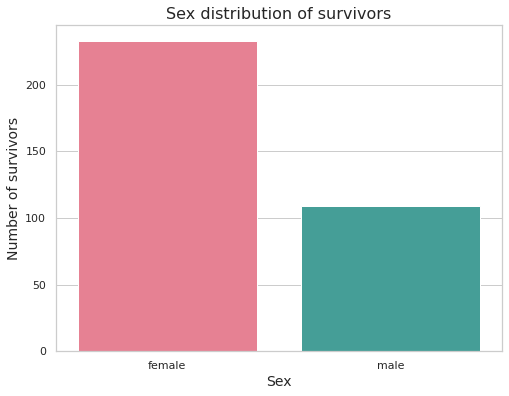

In [48]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns


# 使用DataFrame来更方便地与seaborn配合
survived_sex = df[df['Survived'] == 1]['Sex'].value_counts().reset_index()
survived_sex.columns = ['Sex', 'Count']

# 设置seaborn样式
sns.set(style="whitegrid")

# 创建图表
plt.figure(figsize=(8, 6))

# 绘制柱状图
sns.barplot(x="Sex", y="Count", data=survived_sex, palette="husl")

# 添加标题和轴标签
plt.title("Sex distribution of survivors", fontsize=16)
plt.xlabel("Sex", fontsize=14)
plt.ylabel("Number of survivors", fontsize=14)

# 显示图表
plt.show()

#### 4.显示不同客舱乘客生存比例并进行柱状图可视化

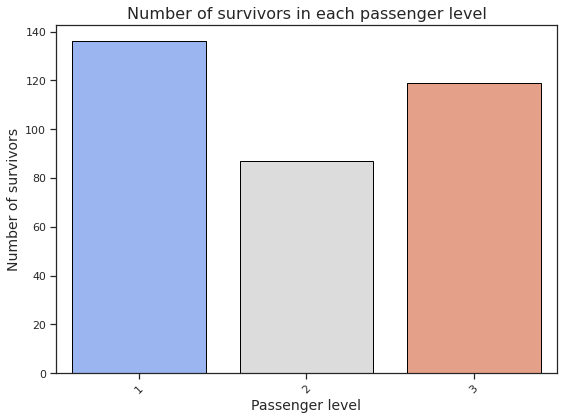

In [49]:
data_df = pd.DataFrame(list(data.items()), columns=['Pclass', 'Survived'])

sns.set_style("ticks")

plt.figure(figsize=(8, 6))

sns.barplot(x='Pclass', y='Survived', data=data_df, palette='coolwarm', edgecolor='black')

# 添加标题和轴标签
plt.title("Number of survivors in each passenger level", fontsize=16)
plt.xlabel("Passenger level", fontsize=14)
plt.ylabel("Number of survivors", fontsize=14)

# 优化显示
plt.xticks(rotation=45)  # 如果乘客等级是字符串，可能需要旋转标签以提高可读性
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域

# 显示图表
plt.show()